# Riyadh Hotel Trends: A Data-Powered Exploration

In [1]:
#import important libraries: 
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import folium
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Import the data 
riyadh_hotels = pd.read_csv('Riyadh_Hotels/Data.csv')
riyadh_hotels.head()

,hotel_id,hotel_name,SOURCE,price,base_price,checkIn,checkOut,count,rating,Info,latitude,longitude
0,15215188,Fairmont Riyadh,all.accor.com,1605.00,NaN,2025-01-02,2025-01-03,220,4.5,NaN,24.808397,46.718050
1,9702375,Rosh Rayhaan by Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,"['Free breakfast available', 'Free cancellation']",24.700346,46.682137
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,NaN,24.785522,46.727880
3,24143026,Joudyan Hotel,MakeMyTrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,"['Free breakfast available', 'Free cancellation']",24.713552,46.675297
4,969150,"Holiday Inn Riyadh - al Qasr, an IHG hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,NaN,24.683914,46.688030


In [3]:
# get the shape of the dataframe
R, C = riyadh_hotels.shape

print(f'Number of rows is { R }', f'and Number of coloumns is { C }')

Number of rows is 1089 and Number of coloumns is 12


# 1. Data Cleaning

## 1.2. Dealing with Missing Values

In [4]:
# Identify all the missing values in our data
Missing_data = riyadh_hotels.isnull()
print(Missing_data.sum())

hotel_id        0
hotel_name      0
SOURCE          0
price          60
base_price    249
checkIn         0
checkOut        0
count           0
rating          0
Info          758
latitude      438
longitude     438
dtype: int64


In [5]:
# Before starting dealing with the missing values, we will convert headers of the columns to lowercase
riyadh_hotels.columns = riyadh_hotels.columns.str.lower()

### 1.2.1 Price and base_price missing values

<div style="font-size:18px; line-height:2;">
Sine the price column is very important, we will impute the missing value depending on the following:
    
- Mean if price is normally distributed.
- Median if the price has outliers.
- Liner regression, if mean and median don't work well.

<div style="font-size:18px; line-height:2;">
    
- A statistical test for normality can be used to confirm this. If the p-value > 0.05, it indicates that the data likely follows a normal distribution (we fail to reject the null hypothesis).

In [6]:
# Perform the Shapiro-Wilk test
stat, p_value = stats.shapiro(riyadh_hotels['price'].dropna())
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

# Interpretation
if p_value > 0.05:
    print("The data follows a normal distribution (Fail to reject H0).")
else:
    print("The data does not follow a normal distribution (Reject H0).")

Shapiro-Wilk Test Statistic: 0.741219162940979
p-value: 3.0833826129061665e-37
The data does not follow a normal distribution (Reject H0).


<p style="font-size:18px; line-height:2">
- Based on this, the prices in the dataset are not normally distributed, so it is not recommended to use the mean to fill the missing data.

<p style="font-size:18px; line-height:2">
- Now, we will try to use the median. The median is recommended if the data is not normally distributed or if it is skewed. 
- Let's check the shape of the price data and determine if it is skewed.

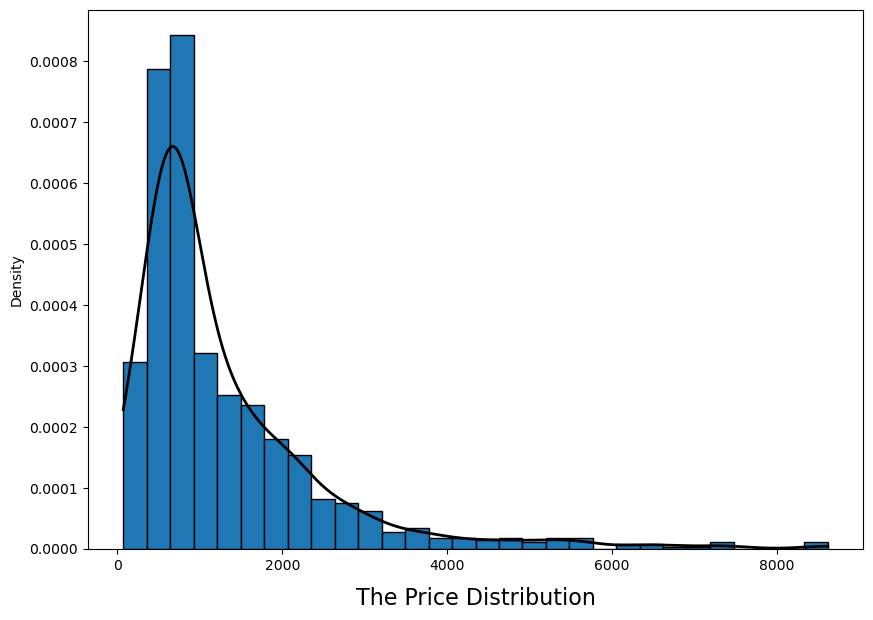

In [7]:
# Plot the histogram
# Choose the density to be True, to overlay it correctly with a Kernel Density Estimate (KDE). 
plt.figure(figsize=(10, 7))
plt.hist(riyadh_hotels['price'], bins=30, density = True, edgecolor='black')

# To make the distribution smoother and more continuous, create a Kernel Density Estimate (KDE) using scipy
kde = stats.gaussian_kde(riyadh_hotels['price'].dropna())

x = np.linspace(min(riyadh_hotels['price'].dropna()), max(riyadh_hotels['price'].dropna()), 1000)
plt.plot(x, kde(x), color='black', linewidth=2)
plt.title('The Price Distribution', y=-0.12, fontsize=16)
plt.ylabel('Density')
plt.show()


<div style="font-size:18px; line-height:2;">

- It is clear that the price data is right-skewed or positvely skewed distribution. 

- Thus, the median is better for filling missing values because it is less influenced by extreme high-priced outliers. The mean can be skewed by a few very expensive hotels, leading to inaccurate estimates. The median provides a more reliable representation of "typical" hotel prices. However, we should carefully handle filling the missing prices with the median to avoid introducing any bias or distorting the relationship between price and other factors.


In [8]:
median_price = riyadh_hotels['price'].median()

# Replcae the missing values in the price column with the median value ( in a copy of the orginal data)
riyadh_hotels_copy = riyadh_hotels.copy()
riyadh_hotels_copy['price'].fillna(median_price, inplace= True)
riyadh_hotels_copy['price'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
1084    False
1085    False
1086    False
1087    False
1088    False
Name: price, Length: 1089, dtype: bool

<div style="font-size:18px; line-height:2;">
- Now, we will investigate whether filling the missing data with the median introduces any bias or distorts the relationship between price and other factors such as base price.

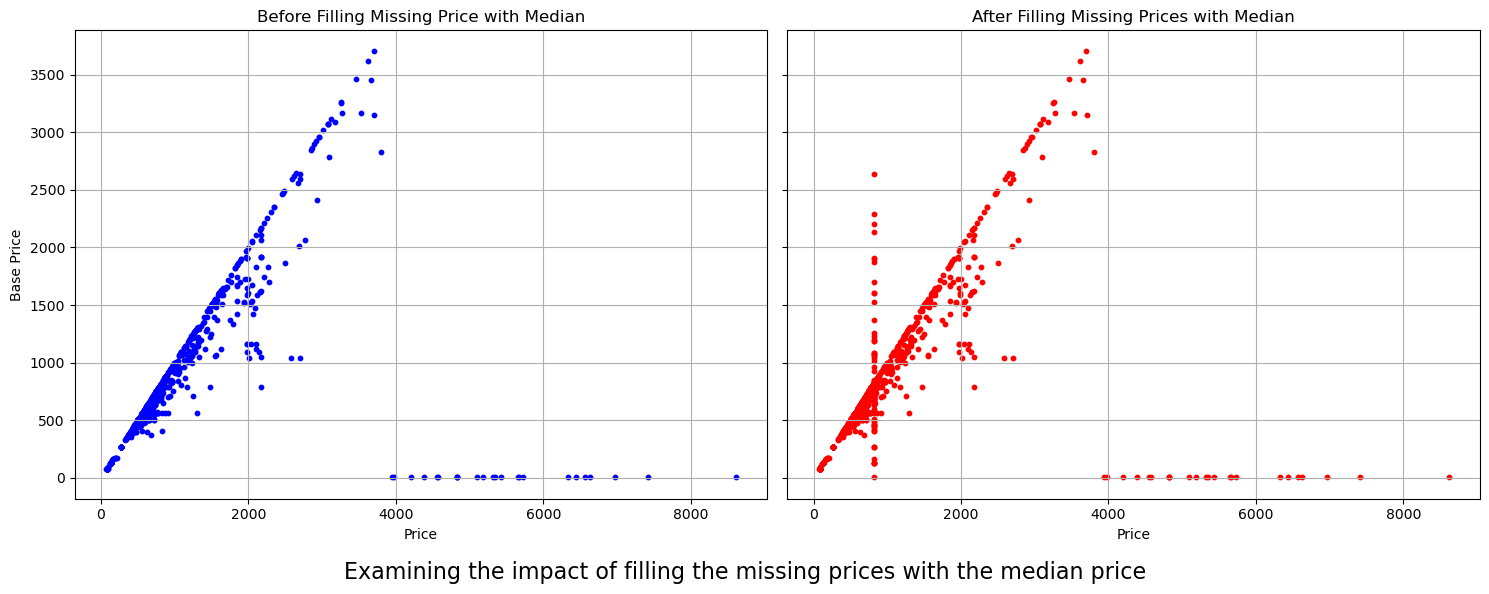

In [9]:
# Create a figure with subplots 
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey =True)

# Before filling missing values in price
axes[0].scatter(riyadh_hotels['price'], riyadh_hotels['base_price'], color='blue', s=10)
axes[0].set_title('Before Filling Missing Price with Median')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Base Price')
axes[0].grid(True)

# After filling missing values in price
axes[1].scatter(riyadh_hotels_copy['price'], riyadh_hotels_copy['base_price'], color='red',s=10)
axes[1].set_title("After Filling Missing Prices with Median")
axes[1].set_xlabel("Price")
axes[1].grid(True)

# Add a global title for the entire figure
fig.suptitle('Examining the impact of filling the missing prices with the median price', y=-0.007, fontsize=16)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [10]:
# Exploring the correlation between price and base_price after filling the missing prices with the median.
correlation_price_base_price = riyadh_hotels_copy['price'].corr(riyadh_hotels_copy['base_price'])
round(correlation_price_base_price, 2)

0.42

<div style="font-size:18px; line-height:2;">
    
- It is clear that filling the missing prices wtih median price is not a good choice since it distorts the correlation between the price and base price. Thus, we will go with the third option which is linear regression. 


- It can be observed that there is a strong correlation between price and base price when the price is below or equal to 3900. However, for prices above 3900, the corresponding base prices are almost zero. These zero values are likely erroneous, as the base price cannot logically be zero.


- To address this, we will eliminate these zero values when calculating the correlation between price and base price. This correlation will then be used to fill in the missing values in both the price and base price columns, as well as to replace the erroneous zero values.

 Regression equation: base_price =  0.89 * price +  25.83
Correlation Coefficient (R): 0.97


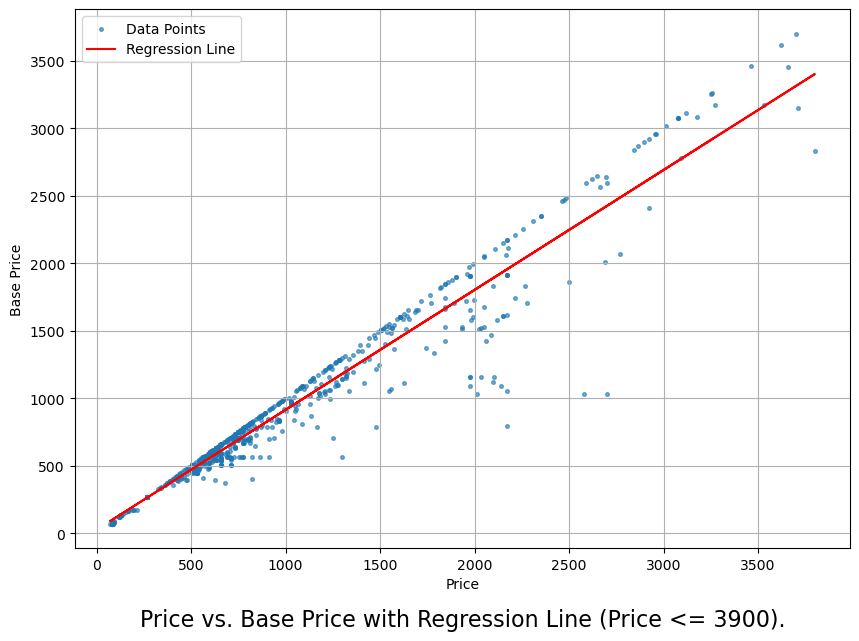

In [11]:
# Filter the data where 'price' is less than or equal to 3900
filtered_hotels = riyadh_hotels[(riyadh_hotels['price'] <=3900) &
                                 (riyadh_hotels['price'].notna()) &
                                 (riyadh_hotels['base_price'].notna())]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(filtered_hotels['price'], filtered_hotels['base_price'])

# Print the regression equation and correlation
print(f" Regression equation: base_price = {slope: .2f} * price + {intercept: .2f}")
print(f"Correlation Coefficient (R): {r_value:.2f}")

# Plot the data and regression line
plt.figure(figsize=(10, 7))
plt.scatter(filtered_hotels['price'], filtered_hotels['base_price'], alpha=0.6, label="Data Points", s=7)
plt.plot(filtered_hotels['price'], slope * filtered_hotels['price'] + intercept, color='red', label="Regression Line")
plt.xlabel("Price")
plt.ylabel("Base Price")
plt.title("Price vs. Base Price with Regression Line (Price <= 3900).", y=-0.16, fontsize =16)
plt.legend()
plt.grid(True)
plt.show()


<div style="font-size:18px; line-height:2;">
- The derived linear correlation equation will be used to replace erroneous zero or near-zero values and fill the missing values in the `base_price` and `price` columns.


In [12]:
# Define the regression equation parameters
slope = 0.89
intercept = 25.83

# Create a function to calculate missing or invalid values
def update_values(row):
    if pd.isna(row['price']):
        # Calculate missing price using the regression equation: price = (base_price - intercept) / slope
        row['price'] = (row['base_price'] - intercept) / slope
    if pd.isna(row['base_price']) or row['base_price'] < 10:
        # Calculate missing or near-zero base_price using the regression equation: base_price = slope * price + intercept
        row['base_price'] = slope * row['price'] + intercept
    return row

# Apply the function to update the dataframe
riyadh_hotels = riyadh_hotels.apply(update_values, axis=1)

# Verify changes
print(riyadh_hotels[['price', 'base_price']].head())

     price  base_price
0  1605.00     1454.28
1   813.75      693.75
2  1128.75     1128.75
3   588.75      472.50
4   633.75      633.75


In [13]:
# To ensure there are no missing values in the price and base_price columns. 
riyadh_hotels[['price', 'base_price']].isnull().sum()

price         0
base_price    0
dtype: int64

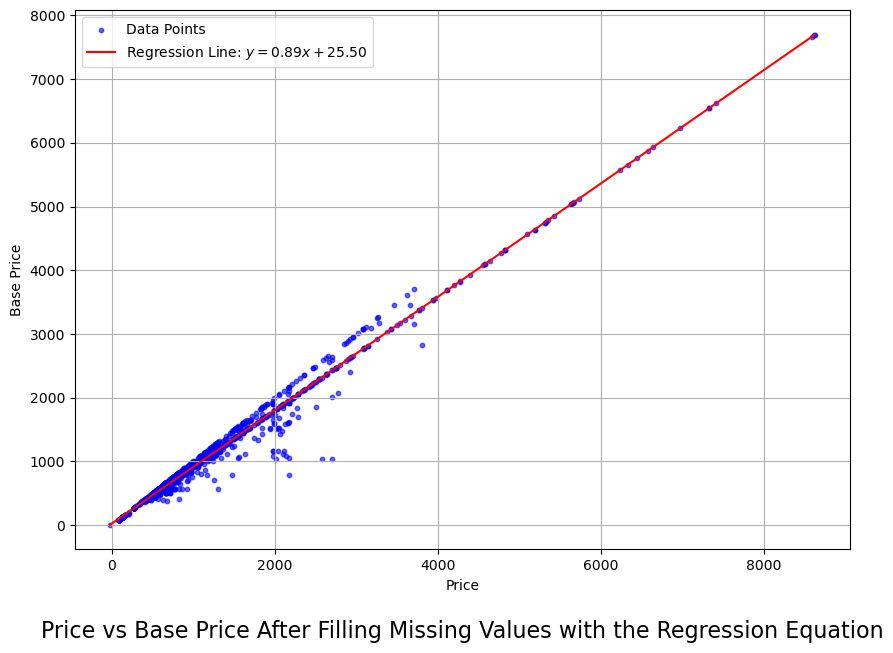

In [14]:
# Plot Price vs Base Price
plt.figure(figsize=(10, 7))
plt.scatter(riyadh_hotels['price'], riyadh_hotels['base_price'], alpha=0.6, color='blue', s=10, label="Data Points")

# Overlay the regression line: base_price = 0.89 * price + 25.50
x_values = np.linspace(riyadh_hotels['price'].min(), riyadh_hotels['price'].max(), 100)
y_values = 0.89 * x_values + 25.50
plt.plot(x_values, y_values, color='red', label="Regression Line: $y = 0.89x + 25.50$")

# Add labels, title, and legend
plt.title("Price vs Base Price After Filling Missing Values with the Regression Equation", y=-0.18, fontsize=16)
plt.xlabel("Price")
plt.ylabel("Base Price")
plt.grid(True)
plt.legend()
plt.show()

### 1.2.2. Missing Values in 'Info' Column


<div style="font-size:18px; line-height:2;">
    
- The 'Info' column contains details about the hotels, such as 'free cancellation' and 'free breakfast.' However, this column has 758 missing values, representing 63% of the total values. Due to the high proportion of missing values, it will not be included in the analysis. Therefore, we will delete this column.

In [15]:
# Delete 'Info' column
riyadh_hotels = riyadh_hotels.drop(columns=['info'])
riyadh_hotels.head()

,hotel_id,hotel_name,source,price,base_price,checkin,checkout,count,rating,latitude,longitude
0,15215188,Fairmont Riyadh,all.accor.com,1605.00,1454.28,2025-01-02,2025-01-03,220,4.5,24.808397,46.718050
1,9702375,Rosh Rayhaan by Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,24.700346,46.682137
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,24.785522,46.727880
3,24143026,Joudyan Hotel,MakeMyTrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,24.713552,46.675297
4,969150,"Holiday Inn Riyadh - al Qasr, an IHG hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,24.683914,46.688030


### 1.2.3. 'latitude' and 'longitude' Columns Missing Values

<div style="font-size:18px; line-height:2;">
    
- Both 'latitude' and 'longitude' Columns has 438 missing values. We will identify hotels in the dataset that have missing latitude or longitude values. These geographic coordinates are essential for location-based analysis, and missing data in this context could limit our ability to visualize or analyze the hotels' locations accurately. We will extract the names of these hotels into a separate DataFrame for review.

In [16]:
# Filter hotels with missing latitude or longitude
missing_lat_lon_hotels = riyadh_hotels[riyadh_hotels['latitude'].isna() | riyadh_hotels['longitude'].isna()]

# Create a DataFrame with hotel names in one column
missing_lat_lon_hotels_df = missing_lat_lon_hotels[['hotel_name']].drop_duplicates()

# Display the DataFrame and check the number of the hotels
print(missing_lat_lon_hotels_df)
print(f'The number of hotels with missing latitude and longitude values is {missing_lat_lon_hotels_df.shape[0]}')


                                      hotel_name
6             Fairmont Ramla Serviced Residences
18                          The St. Regis Riyadh
21                       The Ritz-Carlton Riyadh
23                            Le Méridien Riyadh
24                Sheraton Riyadh Hotel & Towers
26                   IntercityHotel Riyadh Malaz
27                             Ramada By wyndham
30                              Sands Inn Hostel
32                              Rand by Wandalus
33                                Warwick Riyadh
34                                Al Oroba Hotel
35                 Riyadh Airport Marriott Hotel
73                                   Erfad Hotel
79                        Al Diafah Hotel Suites
85                   Intour Qurtoba Hotel Suites
96                                Towlan Khurais
102                   Mena Hotel Nasiriah Riyadh
108             Hyatt Place Riyadh Al Sulaimania
145                     JW Marriott Hotel Riyadh
279  Mansard Riyadh,

<div style="font-size:18px; line-height:2;">
    
- We identified 32 hotels with missing location coordinates. To address this, we will search for the coordinates of these hotels in Riyadh and use the retrieved values to fill in the missing data.

In [17]:
# Full hotel data dictionary with latitude and longitude information
Missing_coordinates_hotel_data = {
    "hotel_name": [
        "Fairmont Ramla Serviced Residences", "The St. Regis Riyadh", "The Ritz-Carlton Riyadh", 
        "Le Méridien Riyadh", "Sheraton Riyadh Hotel & Towers", "IntercityHotel Riyadh Malaz",
        "Ramada By wyndham", "Sands Inn Hostel", "Rand by Wandalus", "Warwick Riyadh", 
        "Al Oroba Hotel", "Riyadh Airport Marriott Hotel", "Erfad Hotel", "Al Diafah Hotel Suites",
        "Intour Qurtoba Hotel Suites", "Towlan Khurais", "Mena Hotel Nasiriah Riyadh", 
        "Hyatt Place Riyadh Al Sulaimania", "JW Marriott Hotel Riyadh", 
        "Mansard Riyadh, A Radisson Collection Hotel", "Burj Alhayah Hotel Suites Alfalah", 
        "Voyage Hotel", "Madareem Hotel", "Thwary Hotel Suites", "Braira Al Wezarat", 
        "Novotel Riyadh Sahafa", "Meral Crown Hotel", "Nawara Dala", 
        "Vivienda Hotel Villas Granada", "Ross Hotel", "The Valley Resort", "The Land Resort"
    ],
    "latitude": [
       80956, 24.66678, 24.66593, 24.72892, 24.72769, 24.67222, 24.6757, 24.66603, 24.70715, 
        24.66207, 24.64192, 24.92467, 26.37219, 27.87113, 24.80326, 24.77615, 24.65972, 24.70749, 
        24.79275, 24.78387, 24.80132, 24.6997, 24.79979, 24.81769, 24.67433, 24.80723, 24.79063, 
        24.77925, 24.78893, 24.69923, 24.60026, 24.90854
    ],
    "longitude": [
        46.62389, 46.62644, 46.63086, 46.66796, 46.66528, 46.73603, 46.71555, 46.70629, 46.68756, 
        46.71802, 46.71787, 46.71298, 46.83472, 46.67817, 46.74269, 46.83453, 46.68337, 46.70851, 
        46.63257, 46.65278, 46.6988, 46.64333, 46.71813, 46.61738, 46.71807, 46.62752, 46.73765, 
        46.58684, 46.72684, 46.64202, 46.53685, 46.60411
    ]
}
# # Display the created DataFrame
Missing_coordinates_hotels = pd.DataFrame(Missing_coordinates_hotel_data)
Missing_coordinates_hotels.head()


,hotel_name,latitude,longitude
0,Fairmont Ramla Serviced Residences,80956.00000,46.62389
1,The St. Regis Riyadh,24.66678,46.62644
2,The Ritz-Carlton Riyadh,24.66593,46.63086
3,Le Méridien Riyadh,24.72892,46.66796
4,Sheraton Riyadh Hotel & Towers,24.72769,46.66528


In [18]:
# Merge the original DataFrame with the full hotel DataFrame
# Use the hotel_name column as the key for the merge
riyadh_hotels = pd.merge(riyadh_hotels,Missing_coordinates_hotels,on ='hotel_name', how='left', suffixes =('', '_x'))
#The parameter suffixes=('', '_full') in the pd.merge() function specifies the suffixes to add to 
# overlapping column names during the merge.
riyadh_hotels.head()

,hotel_id,hotel_name,source,price,base_price,checkin,checkout,count,rating,latitude,longitude,latitude_x,longitude_x
0,15215188,Fairmont Riyadh,all.accor.com,1605.00,1454.28,2025-01-02,2025-01-03,220,4.5,24.808397,46.718050,NaN,NaN
1,9702375,Rosh Rayhaan by Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,24.700346,46.682137,NaN,NaN
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,24.785522,46.727880,NaN,NaN
3,24143026,Joudyan Hotel,MakeMyTrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,24.713552,46.675297,NaN,NaN
4,969150,"Holiday Inn Riyadh - al Qasr, an IHG hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,24.683914,46.688030,NaN,NaN


In [19]:
# Fill missing latitude and longitude in the original columns
riyadh_hotels['latitude'] = riyadh_hotels['latitude'].fillna(riyadh_hotels['latitude_x'])
riyadh_hotels['longitude'] = riyadh_hotels['longitude'].fillna(riyadh_hotels['longitude_x'])

# Drop the extra columns created during the merge
riyadh_hotels = riyadh_hotels.drop(columns=['latitude_x', 'longitude_x'])

# Display the updated DataFrame
riyadh_hotels.head()

,hotel_id,hotel_name,source,price,base_price,checkin,checkout,count,rating,latitude,longitude
0,15215188,Fairmont Riyadh,all.accor.com,1605.00,1454.28,2025-01-02,2025-01-03,220,4.5,24.808397,46.718050
1,9702375,Rosh Rayhaan by Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,24.700346,46.682137
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,24.785522,46.727880
3,24143026,Joudyan Hotel,MakeMyTrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,24.713552,46.675297
4,969150,"Holiday Inn Riyadh - al Qasr, an IHG hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,24.683914,46.688030


In [20]:
# Now, check if there are still missing values in the dataframe
riyadh_hotels.isnull().sum()

hotel_id      0
hotel_name    0
source        0
price         0
base_price    0
checkin       0
checkout      0
count         0
rating        0
latitude      0
longitude     0
dtype: int64

## 1.3. Parse Dates into a Standard Format

In [21]:
#Convert all date columns to a standard datetime format

riyadh_hotels['checkin'] = pd.to_datetime(riyadh_hotels['checkin'], errors='coerce')
riyadh_hotels['checkout'] = pd.to_datetime(riyadh_hotels['checkout'], errors='coerce')
#errors='coerce', Handle parsing errors by setting invalid dates to NaT

#Check if any NaT Values exist
is_there_NaT_CheckIn= riyadh_hotels['checkin'].isna().any()
print(f"Does Checkin contain NaT? {is_there_NaT_CheckIn}\n")

is_there_NaT_CheckOut = riyadh_hotels['checkout'].isna().any()
print(f"Does Checkout contain NaT? {is_there_NaT_CheckOut}")

Does Checkin contain NaT? False

Does Checkout contain NaT? False


## 1.4. Removing Duplicates

In [22]:
#Delete teh duplicates
riyadh_hotels= riyadh_hotels.drop_duplicates(subset=None, keep='first', inplace=False)
#subset: Specifies which columns to check for duplicates. If None, all columns are considered.

## 1.5. Text Cleaning

In [23]:
# Cleaning function
def clean_column(name):
    # Capitalize the first letter of each word and remove unnecessary spaces
    clean_name =' '.join(word.capitalize() for word in name.split())
    
    return clean_name
    
# Apply clean_column function on hotel_name and source columns as
riyadh_hotels['hotel_name'] = riyadh_hotels['hotel_name'].apply(clean_column)
riyadh_hotels['source'] = riyadh_hotels['source'].apply(clean_column)
riyadh_hotels.head()

,hotel_id,hotel_name,source,price,base_price,checkin,checkout,count,rating,latitude,longitude
0,15215188,Fairmont Riyadh,All.accor.com,1605.00,1454.28,2025-01-02,2025-01-03,220,4.5,24.808397,46.718050
1,9702375,Rosh Rayhaan By Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,24.700346,46.682137
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,24.785522,46.727880
3,24143026,Joudyan Hotel,Makemytrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,24.713552,46.675297
4,969150,"Holiday Inn Riyadh - Al Qasr, An Ihg Hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,24.683914,46.688030


<div style="font-size:18px; line-height:2;">
    
- To classify any source that is not a booking website as "Official Site", the following code will replace all non-booking sources with the value "Official Site." This can help standardize the data by grouping all official hotel websites into one category. First, we will identify all the unique entries in the "source" column to understand the different sources present in the dataset. Then, we can categorize them accordingly.

In [24]:
riyadh_hotels['source'].unique()

array(['All.accor.com', 'Official Site', 'Booking.com', 'Makemytrip',
       'Fairmont', 'Stregis.com', 'Marriott', 'Agoda.com', 'Expedia',
       'Marriott Hotels', 'Prestigia.com', 'Vio.com', 'Sheraton.com',
       'Lemeridien.com', 'Jw Marriott', 'Hyatt.com', 'Hotels.com',
       'Trip.com'], dtype=object)

In [25]:
# from the obove array, list of booking websites
booking_sites = ['Booking.com', 'Makemytrip', 'Agoda.com', 'Expedia', 'Hotels.com', 'Trip.com']

# Replace all sources that are not booking websites with 'Official Site'
riyadh_hotels['source']=riyadh_hotels['source'].apply(lambda x: x if x in booking_sites else 'Official Site')

# checking the source column
riyadh_hotels['source'].unique()



array(['Official Site', 'Booking.com', 'Makemytrip', 'Agoda.com',
       'Expedia', 'Hotels.com', 'Trip.com'], dtype=object)

# 1.6. Feature Engineering

In [26]:
# Calculate duration of the booking and the price_per_day features
riyadh_hotels['duration'] = (riyadh_hotels['checkout'] - riyadh_hotels['checkin']).dt.days
riyadh_hotels['price_per_day'] = riyadh_hotels['price'] / riyadh_hotels['duration']
riyadh_hotels.head()

,hotel_id,hotel_name,source,price,base_price,checkin,checkout,count,rating,latitude,longitude,duration,price_per_day
0,15215188,Fairmont Riyadh,Official Site,1605.00,1454.28,2025-01-02,2025-01-03,220,4.5,24.808397,46.718050,1,1605.00
1,9702375,Rosh Rayhaan By Rotana,Official Site,813.75,693.75,2025-01-02,2025-01-03,1311,4.5,24.700346,46.682137,1,813.75
2,15756839,Hilton Riyadh Hotel & Residences,Booking.com,1128.75,1128.75,2025-01-02,2025-01-03,1626,4.5,24.785522,46.727880,1,1128.75
3,24143026,Joudyan Hotel,Makemytrip,588.75,472.50,2025-01-02,2025-01-03,317,5.0,24.713552,46.675297,1,588.75
4,969150,"Holiday Inn Riyadh - Al Qasr, An Ihg Hotel",Booking.com,633.75,633.75,2025-01-02,2025-01-03,1073,4.5,24.683914,46.688030,1,633.75


# 2. Data Exploring

In [27]:
# Descriptive Statistics
print("\nDescriptive Statistics")

# Exclude 'hotel_id', 'latitude', and 'longitude' from numerical columns
numerical_columns = riyadh_hotels.drop(columns=['hotel_id', 'latitude', 'longitude']).select_dtypes(include='number')
print("Numerical Columns:\n", numerical_columns.describe().round(2))  # Round numerical stats to 2 decimal places

# For categorical columns, no rounding is applied since they are non-numerical
print("\nCategorical Columns:\n", riyadh_hotels[['hotel_name', 'source']].describe())


Descriptive Statistics
Numerical Columns:
          price  base_price    count   rating  duration  price_per_day
count  1067.00     1067.00  1067.00  1067.00   1067.00        1067.00
mean   1235.07     1123.93   333.56     4.23      2.96         572.02
std    1145.63     1028.58   408.69     0.58      1.40         761.96
min     -24.81        3.75     1.00     2.50      1.00         -24.81
25%     568.12      540.00    54.00     4.00      2.00         182.81
50%     802.50      772.50   214.00     4.50      3.00         330.00
75%    1558.12     1407.55   407.00     4.50      4.00         649.50
max    8617.50     7695.40  1626.00     5.00      5.00        8617.50

Categorical Columns:
                             hotel_name       source
count                             1067         1067
unique                              55            7
top     Sheraton Riyadh Hotel & Towers  Booking.com
freq                                54          622


## 2.1. What are the top 10 most expensive and least expensive hotels? 

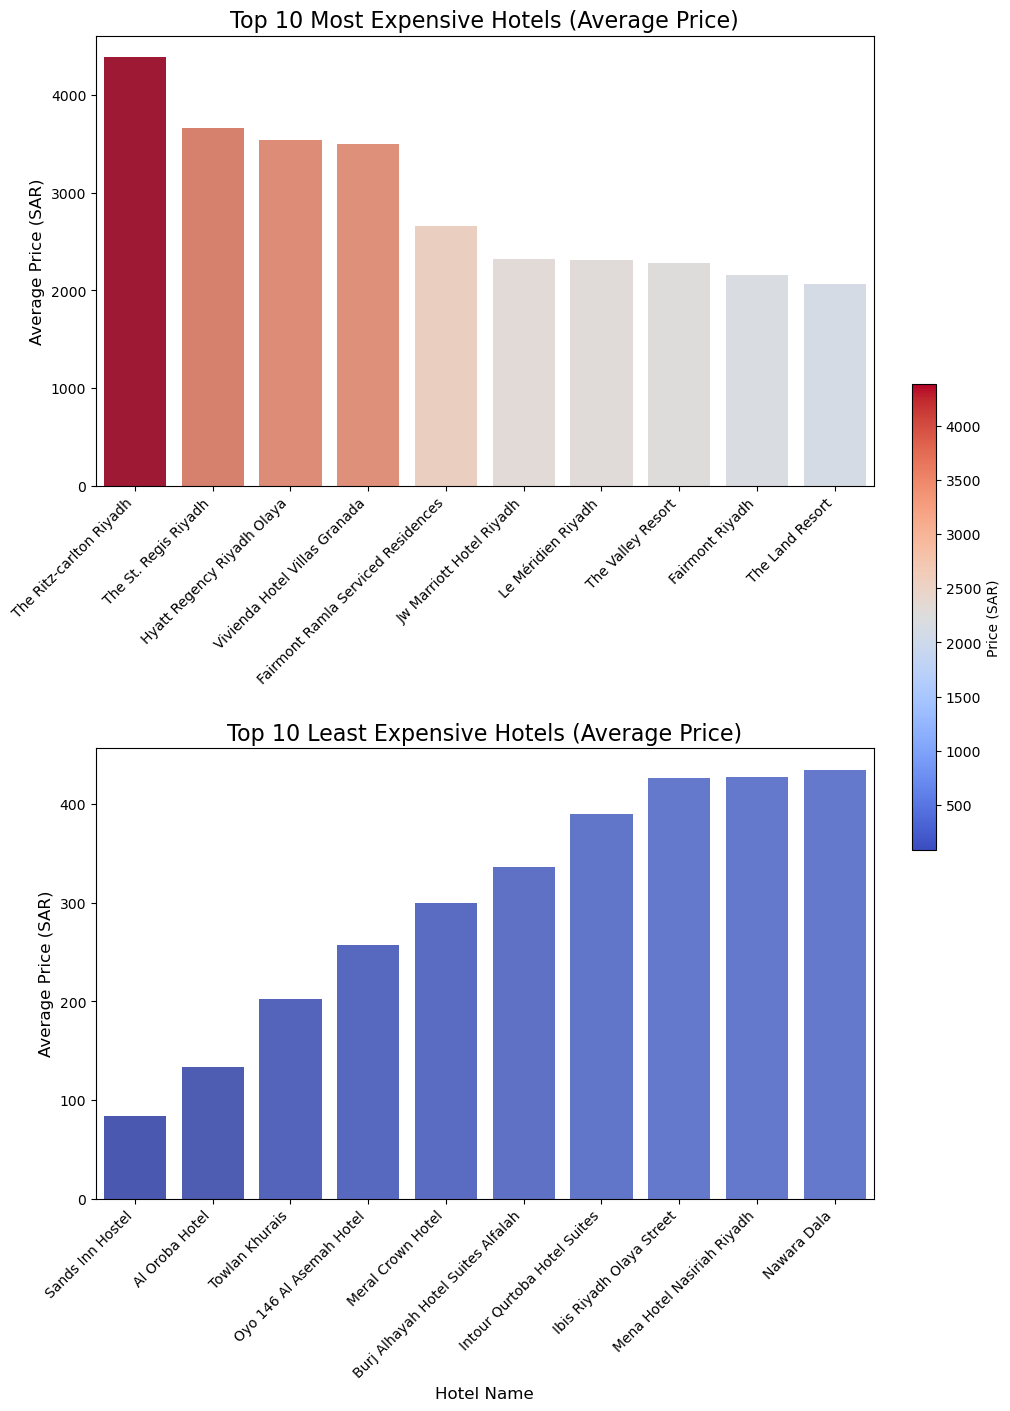

In [28]:
# 1. Group by hotel_name and calculate the average price
avg_price_per_hotel = riyadh_hotels.groupby('hotel_name', as_index=False)['price'].mean()

# 2. Get the top 10 most expensive and least expensive hotels
top_10_most_expensive = avg_price_per_hotel.nlargest(10, 'price')
top_10_least_expensive = avg_price_per_hotel.nsmallest(10, 'price')

# 3. Define a colormap and normalization for the entire range of prices
cmap = plt.colormaps.get_cmap('coolwarm') 
norm = plt.Normalize(avg_price_per_hotel['price'].min(), avg_price_per_hotel['price'].max())

# 4. Create a single figure with two subplots and reduce hspace
fig, axes = plt.subplots(2, 1, figsize=(10, 14), gridspec_kw={'hspace': 0.05}, constrained_layout=True)

# Top 10 most expensive hotels
colors_expensive = [cmap(norm(price)) for price in top_10_most_expensive['price']]
sns.barplot(
    ax=axes[0],
    data=top_10_most_expensive,
    x='hotel_name',
    y='price',
    hue='hotel_name',
    palette=colors_expensive,
    legend=False
)
axes[0].set_title('Top 10 Most Expensive Hotels (Average Price)', fontsize=16)
axes[0].set_ylabel('Average Price (SAR)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_xticks(range(len(top_10_most_expensive['hotel_name'])))
axes[0].set_xticklabels(top_10_most_expensive['hotel_name'], ha='right', rotation=45)

# Top 10 least expensive hotels
colors_least_expensive = [cmap(norm(price)) for price in top_10_least_expensive['price']]
sns.barplot(
    ax=axes[1],
    data=top_10_least_expensive,
    x='hotel_name',
    y='price',
    hue='hotel_name',
    palette=colors_least_expensive,
    legend=False
)
axes[1].set_title('Top 10 Least Expensive Hotels (Average Price)', fontsize=16)
axes[1].set_ylabel('Average Price (SAR)', fontsize=12)
axes[1].set_xlabel('Hotel Name', fontsize=12)
axes[1].set_xticks(range(len(top_10_least_expensive['hotel_name'])))
axes[1].set_xticklabels(top_10_least_expensive['hotel_name'], ha='right', rotation=45)

# 5. Add a single color bar on the side of the entire figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.05, label='Price (SAR)')

# 6. Display the figure
plt.show()


<div style="font-size:18px; line-height:2;">
    
- The analysis of hotel prices in Riyadh shows a significant price gap between the most and least expensive accommodations. Luxury hotels like The Ritz-Carlton Riyadh and The St. Regis Riyadh top the list, with average prices exceeding 3,500 SAR, reflecting their premium services and exclusive locations. In contrast, budget-friendly options such as Sands Inn Hostel and Al Oroba Hotel offer accommodations below 150 SAR, catering to cost-conscious travelers. This stark contrast highlights the diverse hospitality market in Riyadh, accommodating both high-end luxury seekers and budget travelers.

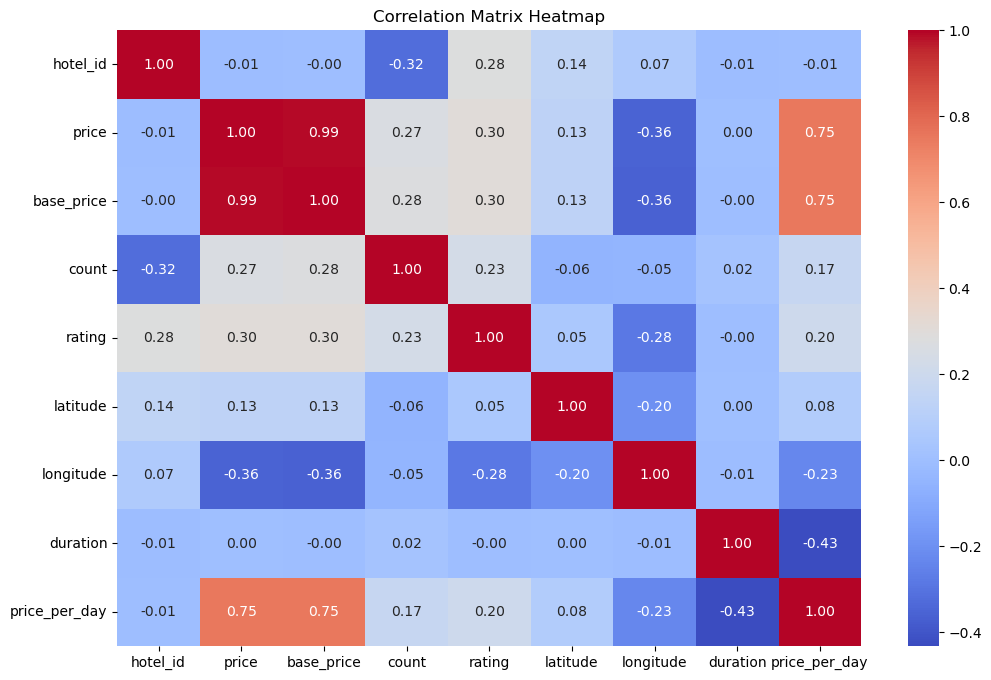

In [29]:
# Compute correlation matrix on numeric columns only
numeric_columns = riyadh_hotels.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## 2.2. Hotel Ratings and Customer Reviews. 

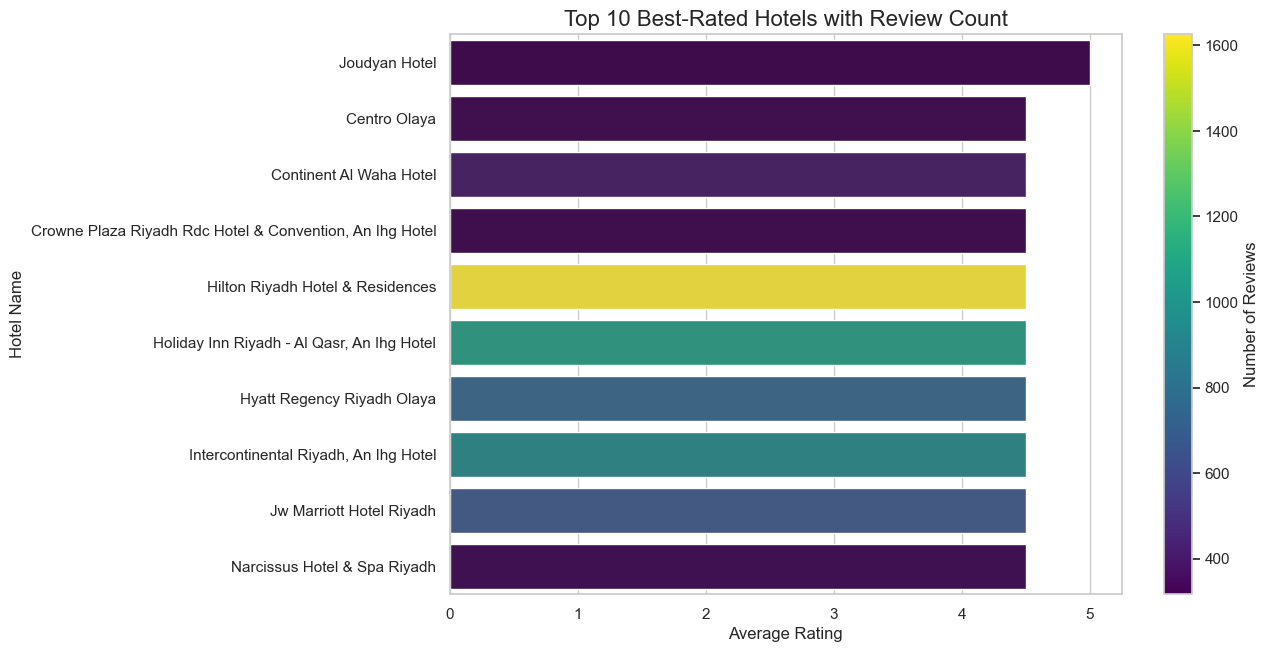

In [40]:
# Step 1: Filter hotels with at least 300 reviews
filtered_hotels = riyadh_hotels[riyadh_hotels['count'] >= 300]

# Step 2: Calculate average ratings and merge with review counts
average_ratings = filtered_hotels.groupby('hotel_name')['rating'].mean().reset_index()
top_10_rated = average_ratings.sort_values(by='rating', ascending=False).head(10)
top_10_rated = top_10_rated.merge(
    filtered_hotels[['hotel_name', 'count']].drop_duplicates(),
    on='hotel_name',
    how='left'
)

# Step 3: Generate colormap for review counts
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=top_10_rated['count'].min(), vmax=top_10_rated['count'].max())
colors = [cmap(norm(count)) for count in top_10_rated['count']]

# Step 4: Plot with color-mapped bars
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=top_10_rated,
    x='rating',
    y='hotel_name',
    hue='hotel_name',            
    palette=colors,              
    legend=False,                
    errorbar=None              
)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Number of Reviews')  # Specify 'ax' parameter

# Formatting
plt.title('Top 10 Best-Rated Hotels with Review Count', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Hotel Name', fontsize=12)
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()


<div style="font-size:18px; line-height:2;">

- Among these top-ten rated hotels, Joudyan Hotel uniquely stands out with a perfect 5.0 rating, while all others hold a solid 4.5. Despite similar ratings, review counts vary considerably—from 317 at Joudyan to 1626 at Hilton Riyadh Hotel & Residences—indicating differences in customer engagement. This curated selection highlights a consistently high quality among leading hotels in Riyadh while also reflecting varied market presence and popularity.

## 2.3. Hotel Locations and Average Prices

In [31]:
# Step 1: Remove duplicates by hotel_name while keeping the first latitude and longitude
unique_hotels = (
    riyadh_hotels.groupby('hotel_name', as_index=False)
    .agg({
        'latitude': 'first',         
        'longitude': 'first',       
        'price_per_day': 'mean'      
    })
)

# Step 2: Create a base map centered around Riyadh
riyadh_map = folium.Map(location=[24.7136, 46.6753], zoom_start=12)

# Step 3: Add markers with size proportional to `price_per_day` and thin edges
for _, row in unique_hotels.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['price_per_day'] / 100,  
        color='blue',  # Circle outline color
        weight=0.5,  # Edge line thickness (thinner)
        fill=True,
        fill_color='green',  # Circle fill color
        fill_opacity=0.7,
        popup=(
            f"Hotel: {row['hotel_name']}<br>"
            f"Avg. Price/Day: {row['price_per_day']:.2f}"
        ),  # Popup with hotel details
    ).add_to(riyadh_map)

# Step 4: Save or display the map
riyadh_map.save("riyadh_hotels_price_map.html") 
riyadh_map


<div style="font-size:18px; line-height:2;">

- The map indicates that the majority of hotels in the dataset are concentrated in the western, northern, and north-eastern areas of Riyadh. This pattern likely reflects thriving commercial zones, better infrastructure, and proximity to key attractions. However, even though the southern and central parts of the city are significant, their underrepresentation in the dataset suggests that the dataset may not fully capture the entire hospitality landscape of the city.

## 2.4. Hotel Price Trends by Booking Source

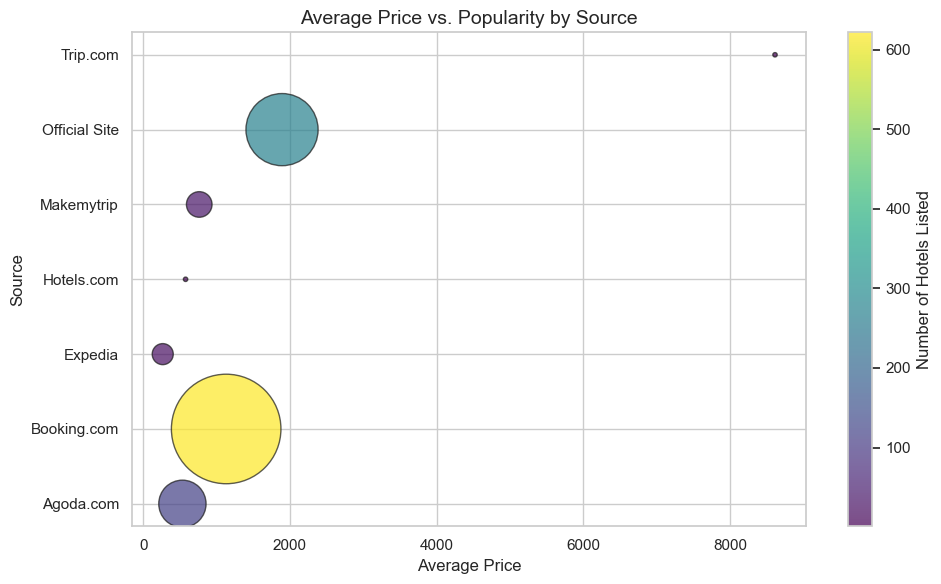

In [42]:

# Set up the plotting style
sns.set_theme(style="whitegrid")

# Calculate the average price by source
avg_price_by_source = riyadh_hotels.groupby('source')['price'].mean().reset_index()

# Calculate platform popularity (count of hotels listed per source)
popularity_by_source = riyadh_hotels['source'].value_counts().reset_index()
popularity_by_source.columns = ['source', 'count']

# Merge the two DataFrames to combine both average price and popularity
combined_data = pd.merge(avg_price_by_source, popularity_by_source, on='source')

# Create a scatter plot with average price on the x-axis, source on the y-axis,
# and popularity represented by the size of the bubbles
plt.figure(figsize=(10, 6))
scatter = plt.scatter(combined_data['price'], combined_data['source'], 
                      c=combined_data['count'], cmap='viridis', 
                      s=combined_data['count']*10, edgecolors='k', alpha=0.7)

# Add a color bar to represent popularity
plt.colorbar(scatter, label='Number of Hotels Listed')

# Set titles and labels
plt.title('Average Price vs. Popularity by Source', fontsize=14)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Source', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


<div style="font-size:18px; line-height:2;">

- The scatter plot shows that Booking.com leads with 622 listings at an average price of about 1131 SAR, indicating high popularity. In contrast, the Official Site of the hotels, with 270 listings, offers significantly higher average prices (around 1893 SAR). Notably, Trip.com appears as an outlier with just one listing at an exceptionally high price of 8613.75 SAR, while platforms like Expedia and Hotels.com have very few listings, suggesting limited data or niche offerings.

## 2.5. Hotel Stay Durations

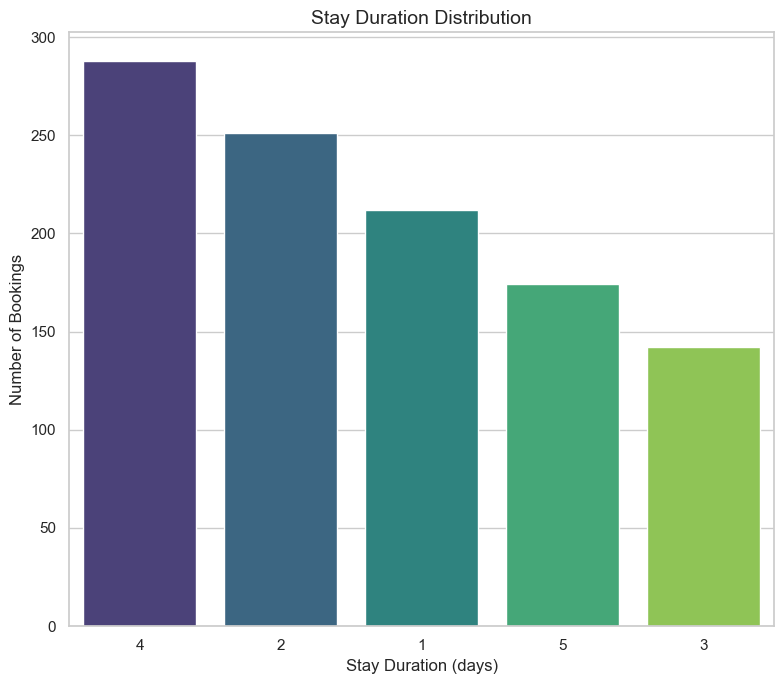

In [50]:
# Analyze stay durations using the 'duration' column
stay_duration_counts = riyadh_hotels["duration"].value_counts().reset_index()
stay_duration_counts.columns = ["stay_duration", "count"]

# Sort the data by 'count' in descending order
stay_duration_counts = stay_duration_counts.sort_values(by="count", ascending=False)

# Plot stay duration distribution with bars sorted from high to low
plt.figure(figsize=(8, 7))
sns.barplot(
    x="stay_duration",
    y="count",
    data=stay_duration_counts,
    order=stay_duration_counts["stay_duration"].tolist(),  # ensures custom ordering
    palette="viridis"
)
plt.title("Stay Duration Distribution", fontsize=14)
plt.ylabel("Number of Bookings", fontsize=12)
plt.xlabel("Stay Duration (days)", fontsize=12)
plt.tight_layout()
plt.show()


<div style="font-size:18px; line-height:2;">
    
- Most hotel stays in Riyadh last between 1 to 4 days, with 4 days being the most common duration. The average stay is approximately 3 days, and short stays (1-2 days) are frequent, likely due to business travelers.

## 2.6. Check-in and Check-out Patterns

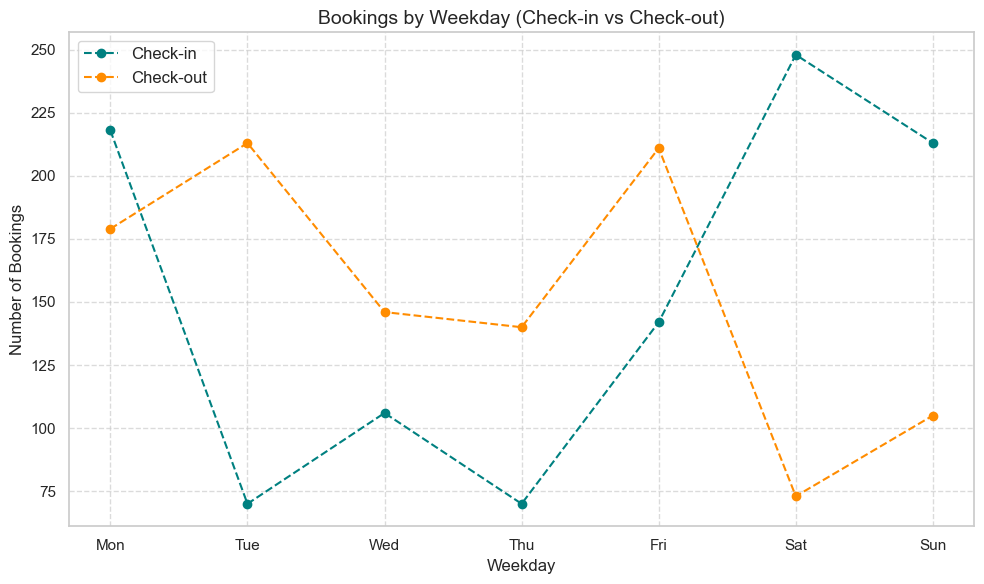

In [34]:
# Convert 'checkin' and 'checkout' columns to datetime format (if not already done)
riyadh_hotels["checkin"] = pd.to_datetime(riyadh_hotels["checkin"])
riyadh_hotels["checkout"] = pd.to_datetime(riyadh_hotels["checkout"])

# Extract weekdays for both check-in and check-out
riyadh_hotels["checkin_weekday"] = riyadh_hotels["checkin"].dt.weekday
riyadh_hotels["checkout_weekday"] = riyadh_hotels["checkout"].dt.weekday

# Count the occurrences of each weekday for check-in and check-out
checkin_counts = riyadh_hotels["checkin_weekday"].value_counts().sort_index()
checkout_counts = riyadh_hotels["checkout_weekday"].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(checkin_counts.index, checkin_counts.values, marker='o', linestyle='--', label="Check-in", color='teal')
plt.plot(checkout_counts.index, checkout_counts.values, marker='o', linestyle='--', label="Check-out", color='darkorange')
plt.title("Bookings by Weekday (Check-in vs Check-out)", fontsize=14)
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<div style="font-size:18px; line-height:2;">

- The data shows that Saturday has the highest number of check-ins (248), while Tuesday has the lowest (70). Check-outs peak on Tuesday (213) and Friday (211), suggesting a pattern where many guests check in on weekends and leave early in the week. The low check-out numbers on Saturdays (73) indicate that guests prefer staying over the weekend. This trend aligns with typical leisure and business travel patterns, where weekends attract more check-ins, and weekdays see higher check-outs.

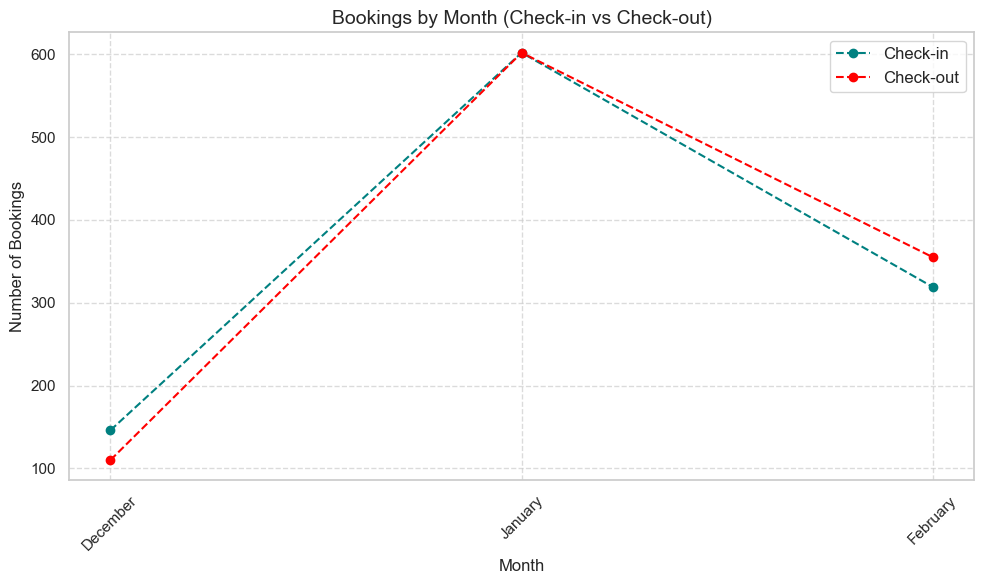

In [35]:
# Extract month names for both check-in and check-out
riyadh_hotels["checkin_month"] = riyadh_hotels["checkin"].dt.month_name()
riyadh_hotels["checkout_month"] = riyadh_hotels["checkout"].dt.month_name()

# Define the natural order for months ( the data only contains three months ): 
month_order = ["December", "January", "February"]

# Count the occurrences of each month for check-in and check-out, reindexing to ensure proper order
checkin_counts = riyadh_hotels["checkin_month"].value_counts().reindex(month_order)
checkout_counts = riyadh_hotels["checkout_month"].value_counts().reindex(month_order)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(month_order, checkin_counts.values, marker='o', linestyle='--', label="Check-in", color='teal')
plt.plot(month_order, checkout_counts.values, marker='o', linestyle='--', label="Check-out", color='red')
plt.title("Bookings by Month (Check-in vs Check-out)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<div style="font-size:18px; line-height:2;">

- The data reveals the booking patterns across three months—December, January, and February. In January, both check-in and check-out counts are notably high and equal, indicating consistent booking and departure rates. December shows fewer bookings overall, with check-outs slightly lower than check-ins, which could indicate longer stays. February shows a dip in check-ins compared to January but has a higher number of check-outs, possibly suggesting a higher turnover of guests in the second half of the month. The limited dataset of just three months restricts generalizations beyond this period.

# Dataset Limitations

<div style="font-size:18px; line-height:2;">

- The dataset covers only three months (December, January, and February), limiting the ability to capture long-term trends, seasonal variations, or events that could influence hotel bookings throughout the year.

- Geographical Bias: The data is concentrated in specific areas of Riyadh, particularly the western, northern, and north-eastern regions. This geographic focus excludes the southern and central parts of the city, which could lead to a skewed representation of the overall hotel market.

- Limited Platform Representation: Some booking platforms, like Expedia and Hotels.com, have very few listings in the dataset. This underrepresentation suggests that the dataset may not reflect the full spectrum of available hotel options or pricing strategies across all platforms.

# Summary

<div style="font-size:18px; line-height:2;">

- Hotel Price Range: Luxury hotels (e.g., Ritz-Carlton) exceed 3,500 SAR, while budget options (e.g., Sands Inn) are below 150 SAR.

- Hotel Ratings: Joudyan Hotel has a perfect 5.0 rating, while others have solid 4.5 ratings. Review counts vary significantly.

- Hotel Location: Most hotels are concentrated in Riyadh’s western, northern, and north-eastern areas, indicating key commercial zones.

- Stay Duration: Most stays last between 1 to 4 days, with 4 days being the most common, likely due to business travelers.

- Booking Platforms: Booking.com has the most listings (622), while Official Sites have higher prices. Trip.com shows one outlier with an extremely high price.

- Check-in/Check-out Trends: Highest check-ins occur on Saturdays (248), and highest check-outs on Tuesdays (213). Guests tend to check out earlier in the week.

- Monthly Trends: January sees the most consistent bookings and check-outs. December shows fewer bookings, and February has higher check-out numbers.